# Generate telluric absorption spectra near 1430 nm for standard terrestrial atmospheric profiles

Tom Schad | 6 March 2024

This notebook uses Py4CAfS to generate telluric absorption spectra near the Si X 1430 nm coronal line. 

The terrestrial atmospheric profile is selected from the standard available in the package. 

The altitude of DKIST is 3067 meters. 


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import glob
import sys
import py4cats 
print(py4cats.__file__)

import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['font.family'] = "serif"
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
from scipy import ndimage

from IPython.display import clear_output


Py4CAtS --- Python for Computational ATmospheric Spectroscopy

A collection of Python scripts for (molecular) line-by-line absorption
(cross sections, optical depths, ...) and atmospheric radiative transfer

https://doi.org/10.3390/atmos10050262    --->   Atmosphere 10(5), 262, 2019
https://atmos.eoc.dlr.de/tools/Py4CAtS/

/home/tschad/dkist_telluric_atlas/py4cats/__init__.py


In [2]:
def vac2air(wave_vac):
    """ 
    Converts wavelengths from vacuum to air-equivalent 
    Morton (2000, ApJ. Suppl., 130, 3043); IAU standard

    wave_vac is given in Angstroms
    
    """
    wave_vac = np.atleast_1d(wave_vac)
    wave_air = np.copy(wave_vac)
    ww  = (wave_vac >= 2000) 
    sigma2 = (1e4 / wave_vac[ww])**2 
    n = 1 + 0.0000834254 + 0.02406147 / (130 - sigma2) + 0.00015998 / (38.9 - sigma2)
    wave_air[ww] = wave_vac[ww] / n
    return wave_air

In [3]:
def air2vac(wave_air): 
    """ Converts wavelengths from air-equivalent to vacuum
    Ciddor (1996) formula
    Adapted from airtovac.pro
    wave_air  :: angstroms 
    
    https://www.astro.uu.se/valdwiki/Air-to-vacuum%20conversion
    
    """
    wave_air = np.atleast_1d(wave_air)
    wave_vac = np.copy(wave_air)
    ww  = (wave_air >= 2000) 
    sigma2 = (1e4 / wave_air[ww])**2 
    n = 1. + 8.336624212083e-5 + 0.02408926869968 / (130.1065924522 - sigma2) + \
        0.0001599740894897 / (38.92568793293 - sigma2)
    wave_vac[ww] = wave_air[ww] * n
    return wave_vac
    

## Set range of wavelengths to use for this notebook

In [4]:
## Here we concentrate on the bandpass near the Si X 1430 nm coronal line. 
wvAng_cen = 14300.   ## Angstrom 
wvAng_range = 60
wnMin,wnMax = 1e8/air2vac( [ wvAng_cen+wvAng_range/2, wvAng_cen-wvAng_range/2. ])  ## convert to wavenumbers in vacuum
print('range of wavenumbers [cm^-1] ',wnMin,'  ',wnMax)

range of wavenumbers [cm^-1]  6976.4598800932    7005.793234004564


In [5]:
## Location of the Hitran database file
hitran_data_file = './HITRAN_VIS_IR/65e912c9.par'

## Load different terrestial atmospheres for comparison 

Here we load standard terrestrial atmosphere profiles to compare their structure and some select molecular concentrations

In [6]:
atmos = 'USstandard_main','subarcticWinter','subarcticSummer','midlatitudeWinter','midlatitudeSummer','tropical',

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels


Text(0.5, 0.98, 'Comparison of Reference Atmospheric Profiles')

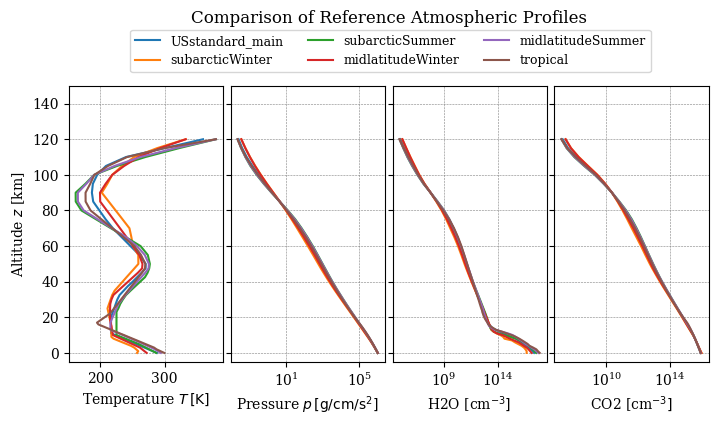

In [7]:
fig,ax = plt.subplots(1,4,figsize = (8,4),sharey=True)
ax = ax.flatten()

for n in range(len(atmos)): 
    
    atmDat = py4cats.atmRead('./py4cats/data/atmos/50/' + atmos[n] + '.xy')
    
    ## plot z vs T
    plt.sca(ax[0])
    py4cats.atmPlot(atmDat,label = atmos[n])
    
    ## plot z vs P
    plt.sca(ax[1])
    py4cats.atmPlot(atmDat,'p',label = atmos[n])
    ax[1].set_xscale('log')

    ## plot h20 and c02 content 
    main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
    for mm in range(2): 
        plt.sca(ax[mm+2])
        py4cats.atmPlot(atmDat,main_mol[mm],label = atmos[n])
        ax[mm+2].set_xscale('log')
    
    ax[3].legend(loc = (-2.75,1.05),fontsize =9,ncol =3)
    ax[0].set_ylim(-5,150)
    for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')
    for axi in ax[1:]:  axi.set_ylabel('')
        
fig.subplots_adjust(0.1,0.1,0.9,0.79,wspace=0.05)
fig.suptitle('Comparison of Reference Atmospheric Profiles',fontsize = 12)


## Now do a finer comparison of 2 atmospheres -- midlatitudewinter and USstandard

In [8]:
atm_midLatWinter = py4cats.atmRead('./py4cats/data/atmos/50/midlatitudeWinter.xy')
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy')  

 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 Atmos1d: got p, T, air   and 7 molecules on 50 levels


In [9]:
#REGRIDDING THE LOWER PORTION OF THE PROFILE FOR FINER SAMPLING 
znew = np.hstack((py4cats.parseGridSpec('0[0.1]7'),atm_midLatWinter['z'][8:]/1e5))
print(' Number of grid layers in regridded atmospheres: ',znew.shape)
atm_midLatWinter = py4cats.atmRegrid(atm_midLatWinter,znew*1e5)
atm_standard  = py4cats.atmRegrid(atm_standard,znew*1e5)

 Number of grid layers in regridded atmospheres:  (113,)
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)


In [10]:
## View Pressure (converted from g/cm/s2 to atm) and Temperature for the lower 10 heights
print(' Height index,  z [km] ,  P (atm) ,  T (K)')
for n in range(10): 
    print('        ',n,'    ', np.round(atm_midLatWinter['z'][n]/1e5,2),'      ',
          np.round(atm_midLatWinter['p'][n]/1000.*100./101325.,2),'     ',np.round(atm_midLatWinter['T'][n],2))

 Height index,  z [km] ,  P (atm) ,  T (K)
         0      0.0        1.0       272.2
         1      0.1        0.99       271.85
         2      0.2        0.98       271.5
         3      0.3        0.97       271.15
         4      0.4        0.96       270.8
         5      0.5        0.94       270.45
         6      0.6        0.93       270.1
         7      0.7        0.92       269.75
         8      0.8        0.91       269.4
         9      0.9        0.9       269.05


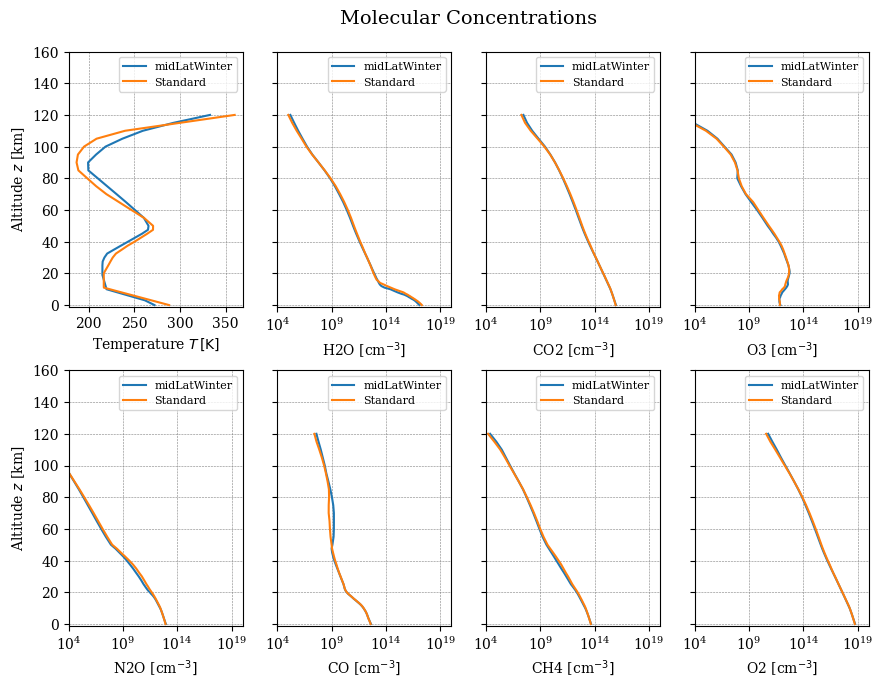

In [11]:
fig,ax = plt.subplots(2,4,figsize = (10,7),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
py4cats.atmPlot(atm_midLatWinter,label = 'midLatWinter')
py4cats.atmPlot(atm_standard,label = 'Standard')
ax[0].legend(loc = 'upper right',fontsize = 8)

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    py4cats.atmPlot(atm_midLatWinter,main_mol[n-1],label = 'midLatWinter')
    py4cats.atmPlot(atm_standard,main_mol[n-1],label = 'Standard')
    ax[n].set_xscale('log')
    ax[n].legend(loc = 'upper right',fontsize = 8)
    
ax[0].set_ylim(-1,160)

for n in range(1,8): 
    ax[n].set_xlim(1e4,1e20)
for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')
for axi in ax[1:4]:  axi.set_ylabel('')
for axi in ax[5:]:  axi.set_ylabel('')

fig.suptitle("Molecular Concentrations",fontsize = 14) 
fig.subplots_adjust(0.1,0.1,0.9,0.92,wspace=0.2,hspace = 0.25)

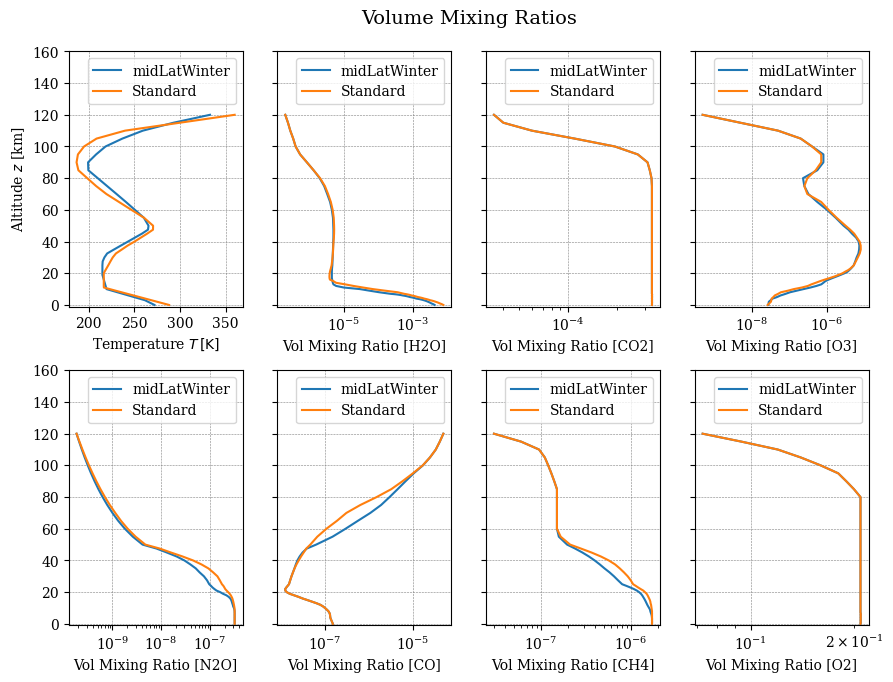

In [12]:
fig,ax = plt.subplots(2,4,figsize = (10,7),sharey=True)
ax = ax.flatten()
plt.sca(ax[0])
py4cats.atmPlot(atm_midLatWinter,label = 'midLatWinter')
py4cats.atmPlot(atm_standard,label = 'Standard')
ax[0].legend(fontsize=10)

main_mol = 'H2O','CO2','O3','N2O','CO','CH4','O2',
for n in range(1,8): 
    plt.sca(ax[n])
    plt.plot(py4cats.vmr(atm_midLatWinter,main_mol[n-1]),atm_midLatWinter['z']/1e5,label = 'midLatWinter')
    plt.plot(py4cats.vmr(atm_standard,main_mol[n-1]),atm_standard['z']/1e5,label = 'Standard')
    plt.xscale('log')
    plt.xlabel('Vol Mixing Ratio ['+main_mol[n-1] + ']')
    ax[n].legend(loc = 'upper right',fontsize=10)
    
ax[0].set_ylim(-1,160)
for axi in ax:  axi.grid(ls = 'dashed',lw = 0.4,color = 'grey')
for axi in ax[1:4]:  axi.set_ylabel('')
for axi in ax[5:]:  axi.set_ylabel('')
fig.suptitle("Volume Mixing Ratios",fontsize = 14) 
fig.subplots_adjust(0.1,0.1,0.9,0.92,wspace=0.2,hspace = 0.25)

## View vertical column densities [molec / cm**2 ] 

In [13]:
print("Vertical column densities [molec / cm**2 ]")
for mol in main_mol: 
    print('---------------- Molecule ----------',mol,'------------------')
    print(f"midLatWinter (full atmo): { py4cats.vcd(atm_midLatWinter,mol,zMin = 0.0):.4}",end = "    |   ") 
    print(f"midLatWinter (above 3km): { py4cats.vcd(atm_midLatWinter,mol,zMin = 3.0):.4}") 
    print(f"US standard (full atmo):  { py4cats.vcd(atm_standard,mol,zMin = 0.0):.4}", end = "    |   ") 
    print(f"US standard  (above 3km): { py4cats.vcd(atm_standard,mol,zMin = 3.0):.4}") 

Vertical column densities [molec / cm**2 ]
---------------- Molecule ---------- H2O ------------------
midLatWinter (full atmo): 2.891e+22    |   midLatWinter (above 3km): 6.689e+21
US standard (full atmo):  4.809e+22    |   US standard  (above 3km): 1.147e+22
---------------- Molecule ---------- CO2 ------------------
midLatWinter (full atmo): 7.151e+21    |   midLatWinter (above 3km): 4.877e+21
US standard (full atmo):  7.118e+21    |   US standard  (above 3km): 4.932e+21
---------------- Molecule ---------- O3 ------------------
midLatWinter (full atmo): 1.02e+19    |   midLatWinter (above 3km): 9.998e+18
US standard (full atmo):  9.29e+18    |   US standard  (above 3km): 9.089e+18
---------------- Molecule ---------- N2O ------------------
midLatWinter (full atmo): 6.47e+18    |   midLatWinter (above 3km): 4.265e+18
US standard (full atmo):  6.622e+18    |   US standard  (above 3km): 4.502e+18
---------------- Molecule ---------- CO ------------------
midLatWinter (full atmo): 2.42

In [14]:
print(' Column Mixing Ratios: --- US standard (full atmo) === midLatWinter (full atmo)')
for mol in main_mol: 
    print(mol.ljust(4) + ':'.ljust(5) + f"{py4cats.cmr(atm_standard,mol):.3e}" + ' ' + f"{py4cats.cmr(atm_midLatWinter,mol):.3e}")

 Column Mixing Ratios: --- US standard (full atmo) === midLatWinter (full atmo)
H2O :    2.231e-03 1.335e-03
CO2 :    3.302e-04 3.302e-04
O3  :    4.309e-07 4.708e-07
N2O :    3.072e-07 2.987e-07
CO  :    1.110e-07 1.120e-07
CH4 :    1.648e-06 1.592e-06
O2  :    2.091e-01 2.091e-01


##  Calculate precipitable water vapor in the atmosphere 

- PWV is measured as the height of water in liquid form at Earth's surface if fully precipited.
- Related to vertical column density (VCD): VCD = rho * PWV * Na / M  

In [15]:
rho = 0.9998  # mass density of water in (g/cm**3)
M  = 18.01528 # average molar mass of water in  (g / mole )
Na = 6.022e23 # Avagadro's number (molec / mole)

V = py4cats.vcd(atm_midLatWinter,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(f"{h:.3f}  millimeters PWV [midLatWinter]")

V = py4cats.vcd(atm_standard,'H2O',zMin = 0.0)
h = V /rho/Na * M * 10  ## millimeters
print(f"{h:.3f}  millimeters PWV [standard]")

8.649  millimeters PWV [midLatWinter]
14.389  millimeters PWV [standard]


## Here we start to work with the HITRAN Database to calculate the telluric absorption spectra

### Load Line List

In [16]:
dictOfLineLists = py4cats.higstract(hitran_data_file,(wnMin,wnMax),molecule = 'main')

# first line in spectral range at record number 1038067 found in 7101537.131363388 sec
 b' 11 6976.460706 1.773E-30 8.918E-01.07720.371 4296.56340.650.001140'
# last  line     accepted 
 b' 61 7005.782900 3.471E-24 0.000E+00.05370.070  562.74000.64-.014000'
# first line not accepted 
 b' 21 7005.793403 7.499E-30 8.281E-05.08220.112 1954.35140.68-.007062'
 main gases only:  deleted  0  of  5  molecules in dict of linelists with originally 2824 lines

 2824 lines of  5  molecule(s) extracted from  ./HITRAN_VIS_IR/65e912c9.par
 returning a dictionary of lineArray's for  H2O O3 CH4 CO2 N2O


### Print strongest three lines of each molecule in line list

In [17]:
print('MOL   WaveNum-MIN   WaveNum-MAX_______Num of Lines')
for k in dictOfLineLists.keys(): 
    print('______________________________________')
    print(k,' ',dictOfLineLists[k]['v'].min(),dictOfLineLists[k]['v'].max(),len(dictOfLineLists[k]))
    wvair = vac2air((1e7/dictOfLineLists[k]['v'])*10)/10.
    strength = dictOfLineLists[k]['S']
    smax = np.flip(np.argsort(strength))
    print('          WNUM        WVAIR NM      STRENGTH (cm^-1 / (molecule cm^-2))')
    for ll in range(3): 
        print(' --- ',ll,' ',dictOfLineLists[k]['v'][smax[ll]],wvair[smax[ll]],strength[smax[ll]])

MOL   WaveNum-MIN   WaveNum-MAX_______Num of Lines
______________________________________
H2O   6976.460706 7005.74819 1269
          WNUM        WVAIR NM      STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6981.112471 1432.0449698655698 1.071e-21
 ---  1   6987.144435 1430.808691328904 8.511e-22
 ---  2   6993.263186 1429.5568043242824 6.637e-22
______________________________________
O3   6976.4721 6996.6808 464
          WNUM        WVAIR NM      STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6995.4886 1429.1020311542027 2.343e-27
 ---  1   6996.297 1428.9369026832017 2.323e-27
 ---  2   6995.3608 1429.1281398168635 2.31e-27
______________________________________
CH4   6976.5067 7005.7829 822
          WNUM        WVAIR NM      STRENGTH (cm^-1 / (molecule cm^-2))
 ---  0   6995.6376 1429.0715926814999 2.336e-23
 ---  1   6995.8148 1429.0353950582353 2.023e-23
 ---  2   6996.4571 1428.9042042559372 1.439e-23
______________________________________
CO2   6976.745778 7005.712866 155
      

### Bar graphs of all lines and their line strengths

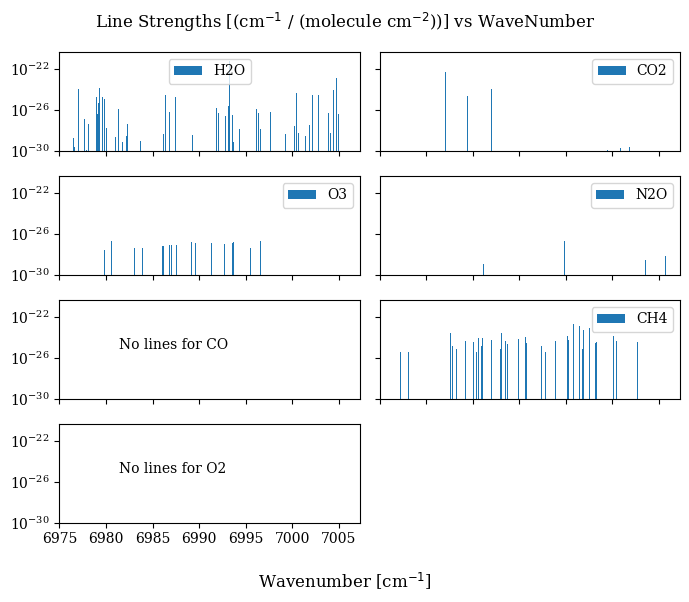

In [18]:
fig,ax = plt.subplots(4,2,figsize = (7,6),sharex=True,sharey=True)
ax = ax.flatten() 
ax[-1].set_visible(False)

for n,mol in enumerate(main_mol): 
    try: 
        ax[n].bar(dictOfLineLists[mol]['v'],dictOfLineLists[mol]['S'],width = 0.005,label = mol)
        ax[n].legend()
    except:
        ax[n].text(0.2,0.5,'No lines for ' + mol,transform = ax[n].transAxes)
        
ax[0].set_yscale('log')
ax[0].set_ylim(1e-30,5e-21)
fig.supxlabel(r'Wavenumber [cm$^{-1}$]')
fig.suptitle(r'Line Strengths [(cm$^{-1}$ / (molecule cm$^{-2}$))] vs WaveNumber',fontsize = 12)
fig.tight_layout()

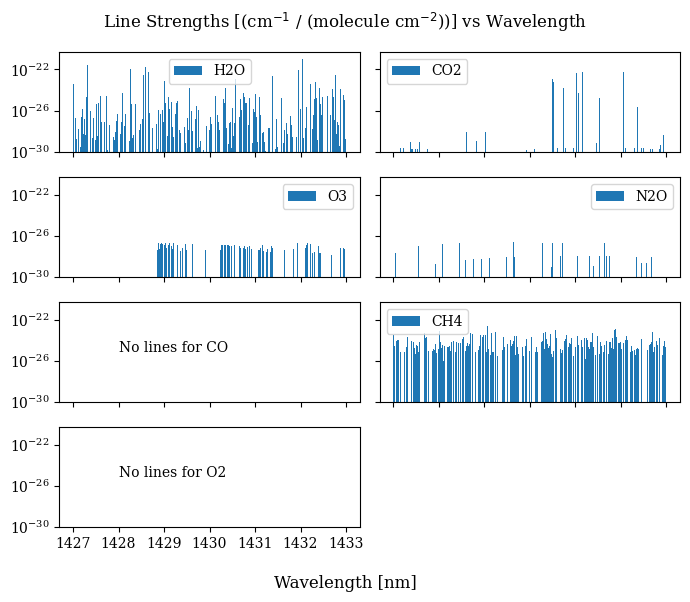

In [19]:
fig,ax = plt.subplots(4,2,figsize = (7,6),sharex=True,sharey=True)
ax = ax.flatten() 
ax[-1].set_visible(False)

for n,mol in enumerate(main_mol): 
    try: 
        wvair = vac2air((1e7/dictOfLineLists[mol]['v'])*10)/10.
        ax[n].bar(wvair,dictOfLineLists[mol]['S'],width = 0.005,label = mol)
        ax[n].legend()
    except:
        ax[n].text(0.2,0.5,'No lines for ' + mol,transform = ax[n].transAxes)
        
ax[0].set_yscale('log')
ax[0].set_ylim(1e-30,5e-21)
fig.supxlabel(r'Wavelength [nm]')
fig.suptitle(r'Line Strengths [(cm$^{-1}$ / (molecule cm$^{-2}$))] vs Wavelength',fontsize = 12)
fig.tight_layout()

## Define Atmosphere for Spectral Synthesis

Here we will using the US standard atmosphere but scale the CO2 concentrations for recent global averages

In [20]:
atm_standard = py4cats.atmRead('./py4cats/data/atmos/50/USstandard_main.xy') ## Using standard atmosphere
znew = np.hstack((py4cats.parseGridSpec('0[0.1]7'),atm_standard['z'][8:]/1e5))  ## regridding
atm_standard  = py4cats.atmRegrid(atm_standard,znew*1e5) 

cmr_co2_std = py4cats.cmr(atm_standard,'CO2',zMin = .0)
print(f"Column Mixing Ratio of CO2 in US standard atmosphere: {cmr_co2_std}") 
cmr_co2_set = 0.000416   ## global average CO2 for Dec 2023 -  417 ppm 
ratio = cmr_co2_set / cmr_co2_std
print(f"Ratio to apply: {ratio:.3f}")
atm_standard['CO2'] = atm_standard['CO2'] * ratio  ## scaling of CO2 

PWV = py4cats.vcd(atm_standard,'H2O',zMin = 0.0)/rho/Na * M * 10  ## millimeters
print(f"PWV {PWV:.2f} millimeters")

## Set selected atmosphere to atmDat for use below
atmDat = atm_standard

 Atmos1d: got p, T, air   and 7 molecules on 50 levels
 atmRegrid with default numpy.interp linear interpolation
 interpolating log(p)
 interpolating log(air)
Column Mixing Ratio of CO2 in US standard atmosphere: 0.0003301722546369477
Ratio to apply: 1.260
PWV 14.39 millimeters


## Get absorption cross sections as a funtion of pressure and temperature in the line list 

In [21]:
xssDict = py4cats.lbl2xs(dictOfLineLists, atmDat['p'], atmDat['T'],(wnMin,wnMax))
clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
print(' DONE --> Outputs cleared')

 DONE --> Outputs cleared


## Calculate absorption coefficients within the atmophere using the cross-sections above. 

In [22]:
absCoList = py4cats.xs2ac(atmDat, xssDict) 

clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
print(' DONE --> Outputs cleared')

 DONE --> Outputs cleared


In [23]:
absCoList[0].info()

air H2O O3 CH4 CO2 N2O     0.0km  1.013e+03mb  288.2K             2497 wavenumbers in  6976.459880 ... 7005.793234 cm-1  with   1.1e-06 < ac <  0.00082


113


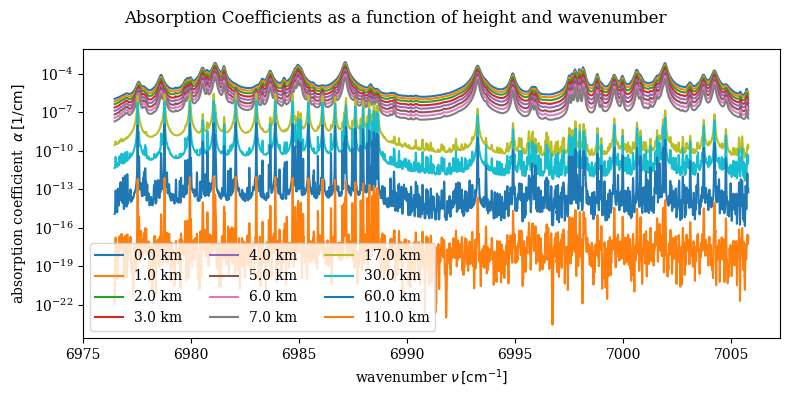

In [24]:
plt.figure(figsize = (8,4))
xUnit='1/cm'
plt.ylabel(r'absorption coefficient  $\alpha \rm\,[1/cm]$')
plt.xlabel(r'wavenumber $\nu \rm\,[cm^{-1}]$')
print(len(absCoList))
for n in range(0,len(absCoList),10): 
    plt.plot(absCoList[n].grid(),absCoList[n],label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')
plt.yscale('log')
plt.legend(ncol = 3)
plt.suptitle('Absorption Coefficients as a function of height and wavenumber')
plt.tight_layout()

## Calculate Optical Depths 

py4cats.ac2dod(abscoList) -->  Integrates absorption coefficient along vertical path thru atmosphere layer-by-layer and return delta optical depths.

py4cats.dod2cod(dodList, back=False) -> Accumulate all delta (layer) optical depths to cumulative optical depths and return a list of odArray's.



In [25]:
## get delta optical depths layer-by-layer 
dodList = py4cats.ac2dod(absCoList)

## change the airmass for a slant geometry if desired
zenith_angle = np.deg2rad(0.)
airmass = 1/np.cos(zenith_angle) 
print(f" Airmass: {airmass:.3f}")
for n in range(len(dodList)): 
    dodList[n] = dodList[n]*airmass  ## airmass

clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
print(' DONE --> Outputs cleared')

 DONE --> Outputs cleared


In [26]:
## Get the cummulative optical depth list 
codList = py4cats.dod2cod(dodList,True)

In [27]:
## Get total optical depth 
tod = py4cats.dod2tod(dodList) 

## Generate and plot the telluric transmission spectra at different heights 

In [28]:
len(codList)

112

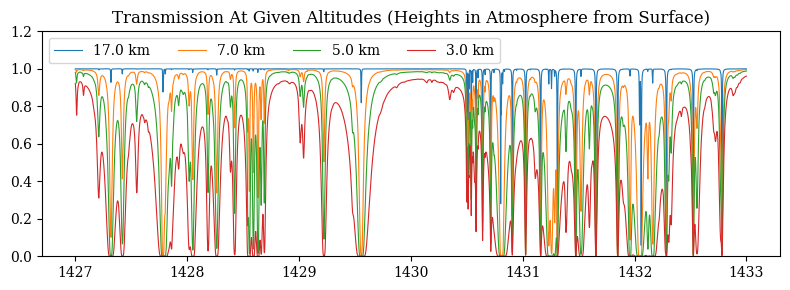

In [29]:
plt.figure(figsize = (8,3))

for n in 80,70,50,30,: 
    wvAir = vac2air((1e7/codList[n].grid() )*10)/10.
    transmission = np.exp(-codList[n])
    plt.plot(wvAir,transmission,lw = 0.8,label = str(np.round(atmDat['z'][n]/1e5,2)) + ' km')

plt.legend(loc = 'upper left',ncol = 4)
plt.ylim(0.,1.2)
plt.title('Transmission At Given Altitudes (Heights in Atmosphere from Surface)')
plt.tight_layout()

## Repeat analysis for molecules in separation! 

* The previous plot show the transmission spectra due to all of the main molecules in the defined atmosphere. 
* This doesnt provide much intuition into which absorbers are contributing the most to the absorption. 
* For this, we can synthesis the transmission function under the approximation that only one molecule is present. 
* This approach is only used to gain some understanding of the various contributing absorbers, and is not an absolute transmission spectra for each molecule, as all molecules work in combination to define the total transmission.  Still, this can be a useful exercise.
* We continue to use the same atmosphere as defined above. 

In [30]:
mol_name = [] ## A list of the molecule names with data available, corresponding to the next list.
mol_cods = [] ## A list of cummulative optical depths for each molecule in isolation 

for mol in main_mol: 
    print(mol)
    try: 
        
        absCoList = py4cats.xs2ac(atmDat, xssDict[mol])    ## absorption coefficients for a single molecule 
        dodList = py4cats.ac2dod(absCoList)   ## delta-optical depths 

        ## change the airmass for a slant geometry if desired
        for n in range(len(dodList)): 
            dodList[n] = dodList[n]*airmass  ## airmass

        ## get ummulative optical depths
        codList = py4cats.dod2cod(dodList,True)  
        
        mol_name.append(mol)
        mol_cods.append(codList)
    
    except:
        print('failed')        

clear_output()      ### py4cats produces a lot of outputs...can clear it here. 
print(' DONE --> Outputs cleared')

 DONE --> Outputs cleared


In [31]:
mol_cods[0][0].grid()

array([6976.45988009, 6976.46149394, 6976.46310779, ..., 7005.7900063 ,
       7005.79162015, 7005.793234  ])

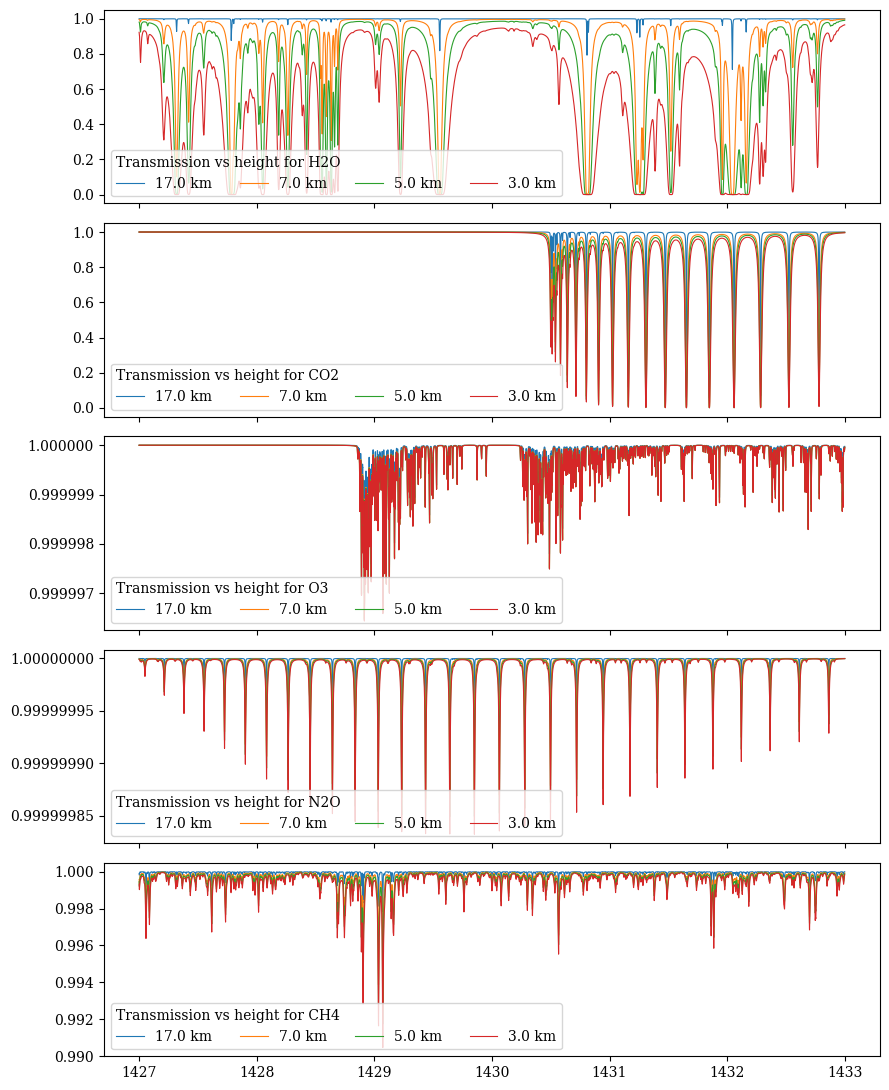

In [32]:
nmol = len(mol_name)

fig,ax = plt.subplots(nmol,1,figsize = (9,11),sharex=True)
ax = ax.flatten() 

for n in range(len(mol_name)): 
    codList = mol_cods[n]
    for zht in 80,70,50,30,: 
        wvAir = vac2air((1e7/codList[zht].grid() )*10)/10.
        transmission = np.exp(-codList[zht])
        ax[n].plot(wvAir,transmission,lw = 0.8,label = str(np.round(atmDat['z'][zht]/1e5,2)) + ' km')
        ax[n].ticklabel_format(useOffset=False)

    leg = ax[n].legend(ncol = 4,title = 'Transmission vs height for ' + mol_name[n],loc = 'lower left')
    leg._legend_box.align = "left"

fig.tight_layout()